In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os

In [24]:
import matplotlib.pyplot as plt

In [2]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [73]:
population_dat = xr.open_dataset('../New_Data/gpw_v4_population_density.2000.2020.CA.nc')

In [74]:
population_dat

<xarray.Dataset>
Dimensions:  (time: 5, lon: 259, lat: 240)
Coordinates:
  * time     (time) float64 2e+07 2.005e+07 2.01e+07 2.015e+07 2.02e+07
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.15 32.11 32.07 32.03
Data variables:
    Band1    (time, lat, lon) float32 ...
Attributes:
    CDI:                 Climate Data Interface version 2.4.4 (https://mpimet...
    Conventions:         CF-1.5
    GDAL_DataType:       Generic
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 3.9.3, released 2024/10/07
    history:             Mon Feb 03 21:51:04 2025: cdo setmissval,0 gpw_v4_po...
    CDO:                 Climate Data Operators version 2.4.4 (https://mpimet...

In [75]:
population_dat = population_dat.to_dataframe().reset_index()

In [76]:
population_dat.head()

,time,lon,lat,Band1
0,20000101.0,-124.766667,41.983333,NaN
1,20000101.0,-124.766667,41.941667,NaN
2,20000101.0,-124.766667,41.900000,NaN
3,20000101.0,-124.766667,41.858333,NaN
4,20000101.0,-124.766667,41.816667,NaN


In [77]:
# time have format like [20000101., 20050101., 20100101., 20150101., 20200101.], we need to convert it to datetime
# first we need to convert it to int so to remove.0
population_dat['time'] = population_dat['time'].astype(int)
population_dat['time'] = pd.to_datetime(population_dat['time'].astype(str), format='%Y%m%d')

In [78]:
population_dat.head()

,time,lon,lat,Band1
0,2000-01-01,-124.766667,41.983333,NaN
1,2000-01-01,-124.766667,41.941667,NaN
2,2000-01-01,-124.766667,41.900000,NaN
3,2000-01-01,-124.766667,41.858333,NaN
4,2000-01-01,-124.766667,41.816667,NaN


In [11]:
# check unique values of time
population_dat['time'].unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2005-01-01 00:00:00', '2010-01-01 00:00:00',
 '2015-01-01 00:00:00', '2020-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

In [8]:
# check unique values of time
population_dat['time'].unique()

array([20000101., 20050101., 20100101., 20150101., 20200101.])

In [79]:
population_dat_lon_lat = population_dat[['lon', 'lat']].drop_duplicates()
population_dat_lon_lat.shape

(62160, 2)

In [14]:
# read reference weather data to confirm the grid is the same
data_dir = '../Weather_Data/'
files = os.listdir('../Weather_Data/')
reference_ds = xr.open_dataset(os.path.join(data_dir, files[-1]))

# Extract lon and lat coordinates
lon = reference_ds.coords['lon'].values
lat = reference_ds.coords['lat'].values

# Create a DataFrame with all combinations of lon and lat
lon_lat_combinations = pd.DataFrame([(lo, la) for lo in lon for la in lat], columns=['lon', 'lat'])

In [15]:
lon_lat_combinations.shape

(62160, 2)

In [16]:
# check if the lon and lat in population data is the same as the reference weather data
test = population_dat_lon_lat.merge(lon_lat_combinations, on=['lon', 'lat'], how='inner')

In [18]:
test.shape

(62160, 2)

Confirmed!

In [21]:
population_dat

,time,lon,lat,Band1
0,2000-01-01,-124.766667,41.983333,NaN
1,2000-01-01,-124.766667,41.941667,NaN
2,2000-01-01,-124.766667,41.900000,NaN
3,2000-01-01,-124.766667,41.858333,NaN
4,2000-01-01,-124.766667,41.816667,NaN
...,...,...,...,...
310795,2020-01-01,-114.016667,32.191667,NaN
310796,2020-01-01,-114.016667,32.150000,NaN
310797,2020-01-01,-114.016667,32.108333,NaN
310798,2020-01-01,-114.016667,32.066667,NaN


In [80]:
population_dat['time'].unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2005-01-01 00:00:00', '2010-01-01 00:00:00',
 '2015-01-01 00:00:00', '2020-01-01 00:00:00']
Length: 5, dtype: datetime64[ns]

In [81]:
# check missing rate in each column
missing_rate = population_dat.isnull().sum() / len(population_dat) * 100
missing_rate

time      0.000000
lon       0.000000
lat       0.000000
Band1    76.911197
dtype: float64

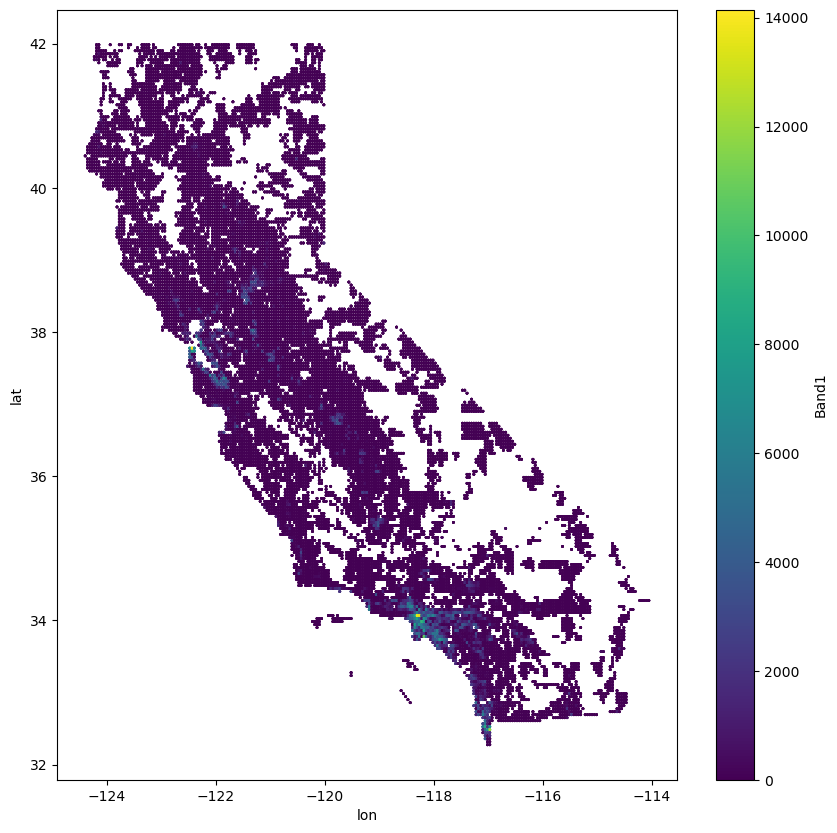

In [25]:
population_dat.plot(kind='scatter', x='lon', y='lat', c='Band1', cmap='viridis', s=1, figsize=(10, 10))
plt.show()

In [82]:
# read first one
reference_ds = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/dead_fuel_moisture_1000hr_filtered.parquet')

In [83]:
reference_ds_lon_lat = reference_ds[['lon', 'lat']].drop_duplicates()
reference_ds_lon_lat.shape

(17530, 2)

In [84]:
population_dat.shape

(310800, 4)

In [85]:
population_dat_filtered = pd.merge(reference_ds_lon_lat, population_dat, on=['lon', 'lat'], how='inner')

In [86]:
population_dat_filtered.shape

(87650, 4)

In [87]:
# check missing rate in each column
missing_rate = population_dat_filtered.isnull().sum() / len(population_dat_filtered) * 100
missing_rate

lon       0.00000
lat       0.00000
time      0.00000
Band1    33.53109
dtype: float64

In [32]:
# write to parquet file
output_file = f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/population_density_2000_2020_filtered.parquet'
population_dat_filtered.to_parquet(output_file)

## MERGE w the FINAL WEATHER CLEANED DATA

after step 02 05

In [33]:
all_features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020.parquet')

In [34]:
all_features.shape

(128056650, 19)

In [35]:
all_features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi                                                float32
pdsi_class                                          float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

In [60]:
# generate a new column called 'year' from the 'time' column
all_features['year'] = all_features['day'].dt.year

In [71]:
population_dat = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/population_density_2000_2020_filtered.parquet')

In [72]:
population_dat.isnull().sum() / len(population_dat) * 100

lon       0.00000
lat       0.00000
time      0.00000
Band1    33.53109
dtype: float64

In [37]:
population_dat.dtypes

lon             float64
lat             float64
time     datetime64[ns]
Band1           float32
dtype: object

In [38]:
# extract year from time
population_dat['year'] = population_dat['time'].dt.year

In [40]:
# get unique years
population_dat['year'].unique()

array([2000, 2005, 2010, 2015, 2020])

In [41]:
population_dat.shape

(87650, 5)

In [48]:
17530*21

368130

In [43]:
# Create a new DataFrame with all the years from 2000 to 2020
years = list(range(2000, 2021))
lon_lat = population_dat[['lon', 'lat']].drop_duplicates()
new_df = pd.DataFrame([(year, lon, lat) for year in years for lon, lat in lon_lat.values], columns=['year', 'lon', 'lat'])

# Define a function to map each year to the nearest specified year
def map_year(year):
    if year <= 2004:
        return 2000
    elif year <= 2009:
        return 2005
    elif year <= 2014:
        return 2010
    elif year <= 2019:
        return 2015
    else:
        return 2020

# Apply the function to create a new column with the mapped years
new_df['mapped_year'] = new_df['year'].apply(map_year)

In [51]:
population_dat.shape[0] == lon_lat.shape[0]*5

True

In [50]:
new_df.shape[0] == lon_lat.shape[0]*21

True

In [52]:
# Merge the new DataFrame with the original DataFrame on the mapped years
population_dat = pd.merge(new_df, population_dat, left_on=['mapped_year', 'lon', 'lat'], right_on=['year', 'lon', 'lat'], suffixes=('', '_original'))

# Drop the original year columns and rename the mapped year column
population_dat = population_dat.drop(columns=['year_original', 'mapped_year'])

In [53]:
population_dat.shape

(368130, 5)

In [62]:
# drop time column
population_dat = population_dat.drop(columns=['time'])

In [63]:
population_dat.sort_values(by=['lon', 'lat']).iloc[21:42]

,year,lon,lat,Band1
0,2000,-124.391667,40.441667,0.443413
17530,2001,-124.391667,40.441667,0.443413
35060,2002,-124.391667,40.441667,0.443413
52590,2003,-124.391667,40.441667,0.443413
70120,2004,-124.391667,40.441667,0.443413
87650,2005,-124.391667,40.441667,0.457414
105180,2006,-124.391667,40.441667,0.457414
122710,2007,-124.391667,40.441667,0.457414
140240,2008,-124.391667,40.441667,0.457414
157770,2009,-124.391667,40.441667,0.457414


In [61]:
# check unique values of year from all_features
all_features['year'].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [70]:
# missing rate in population_dat
population_dat.isnull().sum() / len(population_dat) * 100

year      0.00000
lon       0.00000
lat       0.00000
Band1    33.53109
dtype: float64

In [64]:
# left join all_features and population_dat by ['lon', 'lat', 'year']
all_features = pd.merge(all_features, population_dat, on=['lon', 'lat', 'year'], how='left')

In [65]:
all_features.shape

(128056650, 21)

In [66]:
# drop year column
all_features = all_features.drop(columns=['year'])

In [67]:
all_features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi                                                float32
pdsi_class                                          float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

In [68]:
# check missing rate in each column
all_features.isnull().sum() / len(all_features) * 100

lon                                           0.000000
lat                                           0.000000
day                                           0.000000
dead_fuel_moisture_1000hr                     0.929835
dead_fuel_moisture_100hr                      0.929835
pdsi                                          0.250998
pdsi_class                                    1.180833
max_air_temperature                           0.000000
max_relative_humidity                         0.929835
max_wind_speed                                0.984082
min_air_temperature                           0.000000
min_relative_humidity                         0.929836
precipitation_amount                          0.000000
specific_humidity                             0.929835
surface_downwelling_shortwave_flux_in_air     0.929835
wind_from_direction                           1.053771
wind_speed                                    0.929835
wind_direction_category                       1.053771
SWE       

In [69]:
# write it back to parquet file
output_file = f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020.parquet'
all_features.to_parquet(output_file)